In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna

import matplotlib.pyplot as plt

2023-05-14 16:41:08,335 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [2]:
SEED = 69

import os
os.environ['PYTHONHASHSEED']=str(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

In [3]:
data = pd.read_parquet("data/data_with_feats_4xgb.parquet.gzip")

In [ ]:
features = ["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate"]

data_used_cols = data[features + ["target"]].dropna()
# assert data.shape[0] == data_used_cols.shape[0]

X, y = data_used_cols[features].values, data_used_cols["target"].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.5, random_state=SEED, stratify=y)

In [5]:
data_used_cols.shape

(1793192, 9)

# Predict

In [8]:
def objective(trial):

    VERBOSE_PLOTS = True
    skf = StratifiedKFold(n_splits=5)

    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 200, 600, log=True),
        'subsample': trial.suggest_float('subsample', 0.05, 0.6, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'seed': SEED,
    }

    # Train and test model on each fold
    metrics = []
    for train_index, val_index in list(skf.split(X_train_val, y_train_val))[:3]:
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]
        
        # Train model
        params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False
        )

        if VERBOSE_PLOTS:
            print(params, features)
            results = model.evals_result()
            epochs = len(results['validation_0']['auc'])
            x_axis = range(0, epochs)
            fig, ax = plt.subplots()
            ax.plot(x_axis, results['validation_0']['auc'], label='Train')
            ax.plot(x_axis, results['validation_1']['auc'], label='Test')
            ax.legend()
            plt.ylabel('AUC')
            plt.title('XGBoost AUC')
            plt.show()
    
        # Test model
        y_pred = model.predict_proba(X_val)[:,1]
        metric = roc_auc_score(y_val, y_pred)
        metrics.append(
            metric
        )
        print(
            round(
                metric, 5
            )
        )

        if len(metrics) == 2 and max(metrics) < 0.72:
            break
        
    # print(
    #     f"{round(np.mean(metrics), 5)} +- {round(np.std(metrics), 5)}"
    # )

    return np.mean(metrics)

[I 2023-05-14 16:50:43,240] A new study created in memory with name: no-name-fa550758-63f6-46d2-9810-e812e63f866e


{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 446, 'subsample': 0.4807964868874927, 'learning_rate': 0.05094540387622727, 'seed': 69, 'scale_pos_weight': 12.729346910650026} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate']


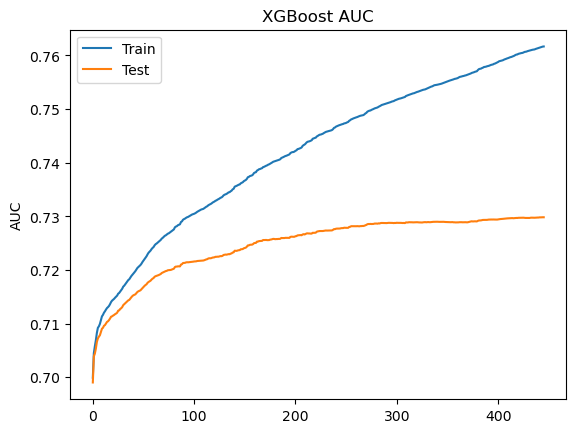

0.72983
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 446, 'subsample': 0.4807964868874927, 'learning_rate': 0.05094540387622727, 'seed': 69, 'scale_pos_weight': 12.729366051604012} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate']


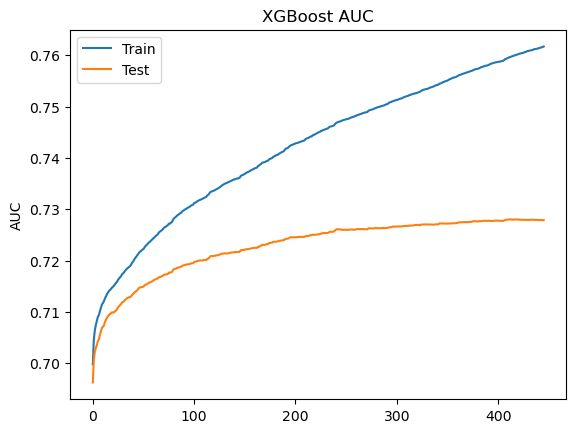

0.72788
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 446, 'subsample': 0.4807964868874927, 'learning_rate': 0.05094540387622727, 'seed': 69, 'scale_pos_weight': 12.729366051604012} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate']


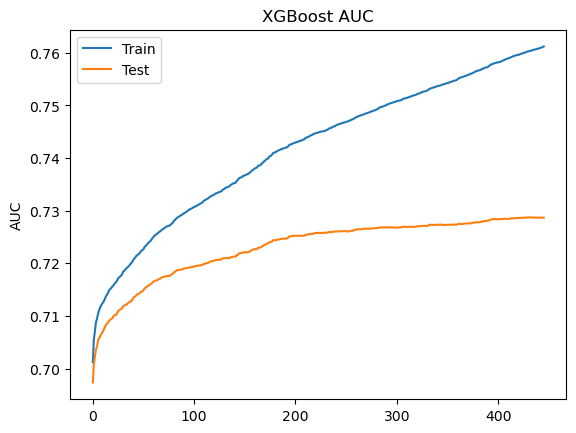

[I 2023-05-14 17:20:13,807] Trial 0 finished with value: 0.7287969754571475 and parameters: {'n_estimators': 511, 'subsample': 0.39395651714408514, 'learning_rate': 0.022070974600440687}. Best is trial 0 with value: 0.7287969754571475.


0.72868
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 446, 'subsample': 0.4807964868874927, 'learning_rate': 0.05094540387622727, 'seed': 69, 'scale_pos_weight': 12.729346910650026} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate']


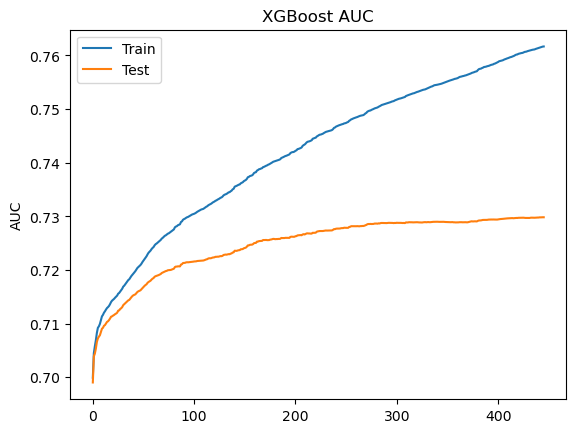

0.72983


In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)

In [ ]:
study.best_trial

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.7214759881486276], datetime_start=datetime.datetime(2023, 5, 14, 7, 44, 44, 528661), datetime_complete=datetime.datetime(2023, 5, 14, 15, 39, 18, 367929), params={'n_estimators': 541, 'subsample': 0.5096596511719927, 'learning_rate': 0.010544541565935218}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=600, log=True, low=200, step=1), 'subsample': FloatDistribution(high=0.6, log=True, low=0.05, step=None), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None)}, trial_id=2, value=None)

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5706904511659537], datetime_start=datetime.datetime(2023, 5, 13, 18, 25, 38, 19301), datetime_complete=datetime.datetime(2023, 5, 13, 18, 27, 1, 321098), params={'subsample': 0.06435314059498777, 'learning_rate': 0.036202388856127116}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.5841330582073612], datetime_start=datetime.datetime(2023, 5, 13, 18, 34, 44, 410982), datetime_complete=datetime.datetime(2023, 5, 13, 18, 36, 35, 19502), params={'subsample': 0.6701497743342159, 'learning_rate': 0.18413715344103385}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)]

FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.6288033226144973], datetime_start=datetime.datetime(2023, 5, 13, 19, 37, 31, 754674), datetime_complete=datetime.datetime(2023, 5, 13, 19, 39, 37, 640029), params={'subsample': 0.36848188910366186, 'learning_rate': 0.0314119110035605, 'features': ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length')}, user_attrs={}, system_attrs={}, intermediate_values={}, 

distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'features': CategoricalDistribution(choices=(('annual_inc', 'loan_amnt'), ('annual_inc', 'loan_amnt', 'fico_average'), ('annual_inc', 'loan_amnt', 'fico_average', 'emp_length')))}, trial_id=18, value=None)

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.6414780581888492], datetime_start=datetime.datetime(2023, 5, 13, 20, 4, 14, 72369), datetime_complete=datetime.datetime(2023, 5, 13, 20, 5, 23, 355636), params={'subsample': 0.22582945179691508, 'learning_rate': 0.014041463069293294}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=0, value=None)

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.6478027939799046], datetime_start=datetime.datetime(2023, 5, 13, 20, 43, 15, 532172), datetime_complete=datetime.datetime(2023, 5, 13, 20, 48, 4, 931532), params={'n_estimators': 297, 'subsample': 0.5023651754403868, 'learning_rate': 0.013297707588788659}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=600, log=True, low=100, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=4, value=None)

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.7056628191146204], datetime_start=datetime.datetime(2023, 5, 13, 20, 57, 13, 758039), datetime_complete=datetime.datetime(2023, 5, 13, 21, 3, 26, 599971), params={'n_estimators': 386, 'subsample': 0.5802227354327434, 'learning_rate': 0.018175234298120842}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=400, log=True, low=150, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)

["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate"]

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.7287969754571475], datetime_start=datetime.datetime(2023, 5, 13, 22, 43, 47, 756604), datetime_complete=datetime.datetime(2023, 5, 13, 22, 51, 10, 782720), params={'n_estimators': 446, 'subsample': 0.4807964868874927, 'learning_rate': 0.05094540387622727}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=True, low=200, step=1), 'subsample': FloatDistribution(high=0.6, log=True, low=0.05, step=None), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None)}, trial_id=0, value=None)

# Wrong

["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "dti"]

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.7042695763788417], datetime_start=datetime.datetime(2023, 5, 13, 21, 23, 14, 409457), datetime_complete=datetime.datetime(2023, 5, 13, 21, 26, 2, 806772), params={'n_estimators': 195, 'subsample': 0.050919411040719585, 'learning_rate': 0.02744129835382001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=True, low=150, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=2, value=None)



["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "initial_list_status"]

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.7055814865786371], datetime_start=datetime.datetime(2023, 5, 13, 22, 0, 25, 924283), datetime_complete=datetime.datetime(2023, 5, 13, 22, 6, 5, 514102), params={'n_estimators': 369, 'subsample': 0.5376649220043659, 'learning_rate': 0.049542498705915004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=True, low=150, step=1), 'subsample': FloatDistribution(high=0.6, log=True, low=0.05, step=None), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None)}, trial_id=4, value=None)

["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "initial_list_status"]